In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torchvision import transforms

import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image

import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class MRLDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.transforms = transforms.Compose([transforms.Resize([24, 24]),
                                              transforms.ToTensor()]) 
        self.img_paths = []
        self.img_labels = []

        # Traverses all subfolders and stores the path and label of each training example
        subfolders = os.listdir(path)
        for folder in subfolders:
            p = os.path.join(path, folder)

            if os.path.isdir(p):                                                    # ignores documentation files
                imgs = os.listdir(p)

                for file_name in imgs:
                    self.img_paths.append(os.path.join(p, file_name))               # append image path
                    self.img_labels.append(int(file_name.split("_")[4]))            # append eye state label
    
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("RGB") 
        img = self.transforms(img)
        label = self.img_labels[idx]

        return (img, label)

In [ ]:
# define a 2-layer artificial neural network
class DrowsinessDetection(nn.Module):
    def __init__(self):
        super(DrowsinessDetection, self).__init__()
        self.name = "drowsy"
        self.layer1 = nn.Linear(24 * 24 * 3, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 2)
        
    def forward(self, img):
        flattened = img.view(-1, 24 * 24 * 3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = F.relu(activation2)
        activation3 = self.layer3(activation2)
        activatio3 = activation3.squeeze()
        return activation3

In [ ]:
def evaluate(model, loader, criterion = None):
    total_losses = 0
    total_correct = 0
    total_examples = 0

    for i, [inputs, labels] in enumerate(loader):
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        
        # Track total loss
        if criterion:
            loss = criterion(outputs, labels)
            total_losses += loss.item()

        # Track total correct
        pred = outputs.argmax(dim = 1)
        total_correct += pred.eq(labels).sum().item()
        total_examples += inputs.shape[0]

    if criterion:
        return total_losses/(i+1), total_correct/total_examples 
    else:
        return total_correct/total_examples


def train(model, train_loader, valid_loader, learning_rate = 0.001, num_epochs = 10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    iters, train_losses, valid_losses, train_acc, valid_acc = [], [], [], [], []


    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)                     # forward pass

            loss = criterion(outputs, labels)           # calculate loss
            loss.backward()                             # calculate gradients using backprop
            optimizer.step()                            # apply optimizer step
            optimizer.zero_grad()                       # zero the gradients

        # Calculate and record loss/accuracy values
        [l, a] = evaluate(model, train_loader, criterion)
        train_losses.append(l)
        train_acc.append(a)

        [l, a] = evaluate(model, valid_loader, criterion)
        valid_losses.append(l)
        valid_acc.append(a)

        iters.append(epoch)

        
    # Plot training curves
    plt.title("Training Curve - Loss")
    plt.plot(iters, train_losses, label = "Training")
    plt.plot(iters, valid_losses, label = "Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Loss: {}".format(train_losses[-1]))
    print("Final Validation Loss: {}".format(valid_losses[-1]))
    print()

    plt.title("Training Curve - Accuracy")
    plt.plot(iters, train_acc, label = "Training")
    plt.plot(iters, valid_acc, label = "Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(valid_acc[-1]))

In [ ]:
# Create Dataset object
dataset = MRLDataset("/content/drive/MyDrive/APS360 Project/MRL")       # Pass in root folder of dataset

# Random split (70-15-15)
n = len(dataset)
n_train = int(0.7 *n)
n_valid = int(0.15 *n)
n_test = n - n_train - n_valid

[train_set, valid_set, test_set] = torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])

# 1% of datasets
train_set = torch.utils.data.Subset(train_set, range(int(0.01 * len(train_set))))
valid_set = torch.utils.data.Subset(valid_set, range(int(0.01 * len(valid_set))))
test_set = torch.utils.data.Subset(test_set, range(int(0.01 * len(test_set))))

# Create DataLoaders
batch_size = 32
num_workers = 2
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)

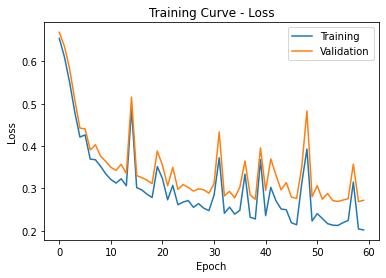

Final Training Loss: 0.20205507819589816
Final Validation Loss: 0.27204811945557594



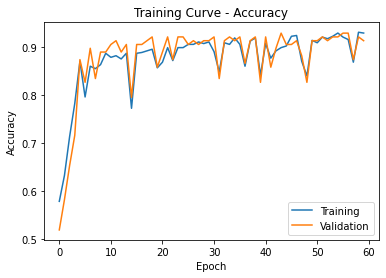

Final Training Accuracy: 0.9292929292929293
Final Validation Accuracy: 0.9133858267716536


In [ ]:
# Train model
drowsy = DrowsinessDetection()
if torch.cuda.is_available():
    drowsy.cuda()

train(drowsy, train_loader, valid_loader, learning_rate = 0.001, num_epochs = 60)

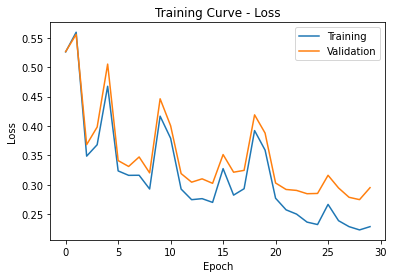

Final Training Loss: 0.22895869240164757
Final Validation Loss: 0.2952047046273947



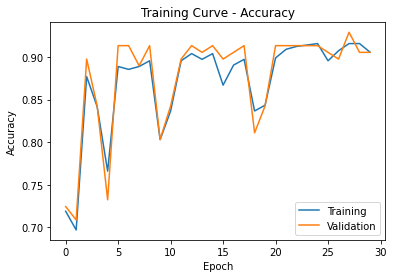

Final Training Accuracy: 0.9057239057239057
Final Validation Accuracy: 0.905511811023622


In [ ]:
# Train model
drowsy2 = DrowsinessDetection()
if torch.cuda.is_available():
    drowsy2.cuda()

train(drowsy2, train_loader, valid_loader, learning_rate = 0.005, num_epochs = 30)

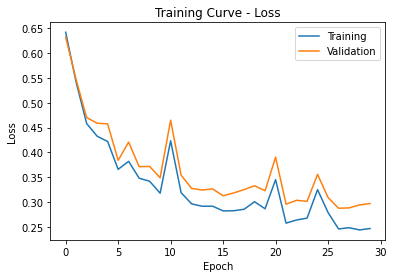

Final Training Loss: 0.24639600476152018
Final Validation Loss: 0.2968199774622917



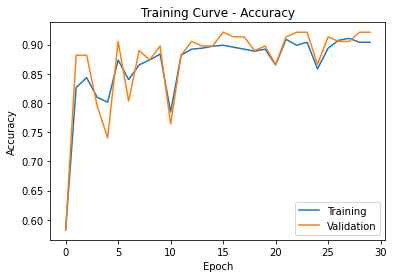

Final Training Accuracy: 0.9040404040404041
Final Validation Accuracy: 0.9212598425196851


In [ ]:
# Train model
drowsy3 = DrowsinessDetection()
if torch.cuda.is_available():
    drowsy3.cuda()

train(drowsy3, train_loader, valid_loader, learning_rate = 0.001, num_epochs = 30)

In [ ]:
evaluate(drowsy3, test_loader)

0.8661417322834646